### [Shrinkage]

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, CSV
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [2]:
m = CSV.read("gastroenterology.txt", header=false)
convert(Array,m[2,:]);

In [3]:
x = zeros(size(m,1)-3,size(m,2))
for i in 4:size(m,1) 
    for j in 1:size(m,2)
        x[i-3,j] = parse(Float64, m[i,j])
    end
end
x = x[vec(sum(abs.(x),2) .!= 0),:]

X = zeros(size(x,1),size(x,2))
mu, sd = vec(mean(x,2)), vec(std(x,2))
for i in 1:size(x,2)
    X[:,i] = (x[:,i]-mu)./sd
end

In [4]:
y = zeros(size(m,2))
for j in 1:size(m,2) 
    label = parse(Int64, m[2,j])
    y[j] = (label>1)
end

In [5]:
d, Nobs = size(X)
σ02 = 1
prior = SS_prior(d, σ02);
d_hyp = hyperparam_size(prior)

932

In [6]:
d, Nobs

(466, 152)

In [7]:
my_ll = ll_logistic(X,y)
my_model = model(my_ll, prior);

In [8]:
# Sub-sampling without control variates and with weights:

mb_size = 1
gs = Array{mbsampler}(d)
gs[1] = umbsampler(0, Nobs, mb_size)

@showprogress for i in 2:d 
    gs[i] = wumbsampler(Nobs, mb_size, abs.(X[i,:]))
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [11]:
A_xi, A_hyp = zeros(50,d), zeros(50,d_hyp)
for i in 1:size(A_xi,1)
    A_xi[i,8*i], A_hyp[i,8*i] = 1, 1 
end

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(3*10^7, 5*10^6)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

In [12]:
adapt_speed = "none"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e1)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [13]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10 percent attempts in 105.09 min; zz bounces = 244158, hyp bounces = 585, total time of process = 57.036 
Trimmed after 5000000 bouncing attempts 
20 percent attempts in 204.52 min; zz bounces = 379868, hyp bounces = 1203, total time of process = 114.418 
30 percent attempts in 294.71 min; zz bounces = 478278, hyp bounces = 1814, total time of process = 172.040 
40 percent attempts in 384.05 min; zz bounces = 568650, hyp bounces = 2399, total time of process = 229.692 
50 percent attempts in 472.84 min; zz bounces = 644300, hyp bounces = 2967, total time of process = 287.475 
60 percent attempts in 561.21 min; zz bounces = 710154, hyp bounces = 3553, total time of process = 345.217 
70 percent attempts in 650.16 min; zz bounces = 773083, hyp bounces = 4185, total time of process = 402.984 
80 percent attempts in 726.61 min; zz bounces = 838359, hyp bounces = 4737, total time of process = 460.788 
90 percent attempts in 768.27 min; zz bounces = 888859, hyp bounces = 5327, total time of

In [14]:
xi_sd = sqrt.(outp.opf.xi_m2 - outp.opf.xi_mu.^2)
ci = zeros(d,2)
ci[:,1] = outp.opf.xi_mu-3*xi_sd
ci[:,2] = outp.opf.xi_mu+3*xi_sd;

Progress:  74%|██████████████████████████████           |  ETA: 0:00:00

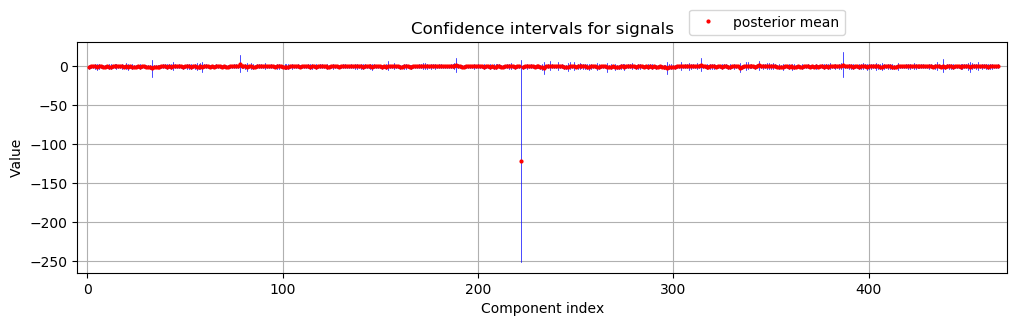

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


PyObject <matplotlib.legend.Legend object at 0x7f59153b50b8>

In [15]:
fig = figure(figsize=(12,3))
@showprogress for i in 1:d
    plot([i,i], ci[i,:], "b-", lw=0.5)
end
plot(1:d, outp.opf.xi_mu, "ro", markersize=2, label="posterior mean");
grid(true)
xlim(-5,d+5)
xlabel("Component index")
ylabel("Value")
title("Confidence intervals for signals")
legend(ncol=2,bbox_to_anchor=(0.65, 1))

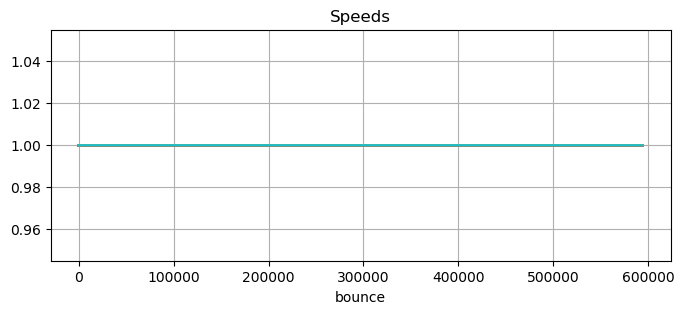

In [16]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:size(outp.opf.alpha_skeleton,1) 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

In [17]:
discard = 0
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

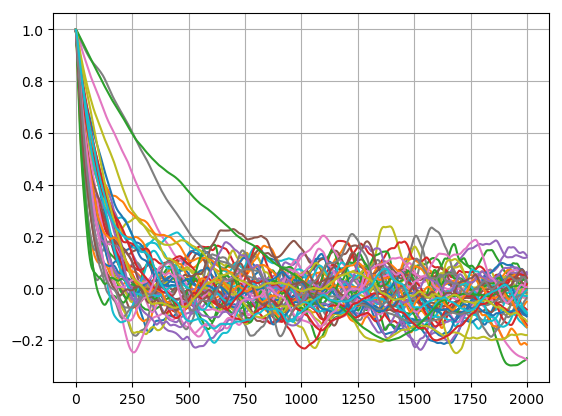

In [18]:
for i in 1:size(xi_samples,1) 
    plot(acf(xi_samples[i,:], 2000))
end
grid(true)

In [19]:
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 1000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 2000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 3000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 4000)) for i in 1:size(xi_samples,1)])), "\n")
print(mean(abs.(size(xi_samples,2)./[sum(acf(xi_samples[i,:], 5000)) for i in 1:size(xi_samples,1)])), "\n")

221.46362287020136
532.6947739623271
494.6562006279822
499.00402288442956
353.4225045866113
